# Active Learning for Image Classification

This notebook implements an iterative active learning pipeline:
1. Sample images (random or active learning query)
2. Annotate via interactive UI
3. Train model
4. Evaluate and repeat

**Workflow**: Run cells sequentially. After first iteration, re-run sampling cell for active learning.

## 1. Configuration

In [3]:
from pathlib import Path
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch

# Project Configuration
PROJECT_NAME = 'shapes'
LABELS = ['circle', 'rectangle', 'star', 'triangle']

# Directory Structure
DATA_DIR = Path('data') / PROJECT_NAME
IMAGE_DIR = DATA_DIR / 'images'
LABEL_DIR = DATA_DIR / 'labels'
MODEL_DIR = DATA_DIR / 'model'

# Active Learning Parameters
RANDOM_SAMPLE_SIZE = 100  # Max images to consider for random sampling
QUERY_METHOD = 'max_entropy'  # Options: 'max_entropy', 'lowest_confidence'
SELECTION_SAMPLE_SIZE = 20  # Number of images to select for annotation
BATCH_SIZE = 10  # Number of images to annotate in UI at once

# Training Parameters
IMAGE_SIZE = 224
EPOCHS = 10
LEARNING_RATE = 1e-3

# Create directories
LABEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Set random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print(f"Project: {PROJECT_NAME}")
print(f"Classes: {LABELS}")
print(f"Image directory: {IMAGE_DIR}")
print(f"Label directory: {LABEL_DIR}")
print(f"Model directory: {MODEL_DIR}")
print(f"\nConfiguration loaded successfully!")

Project: shapes
Classes: ['circle', 'rectangle', 'star', 'triangle']
Image directory: data/shapes/images
Label directory: data/shapes/labels
Model directory: data/shapes/model

Configuration loaded successfully!


## 2. Sample Images for Annotation

Automatically detects if a model exists:
- **No model**: Random sampling from unlabeled images
- **Model exists**: Active learning query (selects most uncertain images)

In [4]:
from fastai.vision.all import *

def get_unlabeled_images():
    """Get list of images without labels."""
    all_images = list(IMAGE_DIR.glob('*.jpg')) + list(IMAGE_DIR.glob('*.png'))
    unlabeled = []
    
    for img_path in all_images:
        label_path = LABEL_DIR / f"{img_path.stem}.txt"
        if not label_path.exists():
            unlabeled.append(img_path)
    
    return unlabeled

def get_labeled_images():
    """Get list of images with labels."""
    labeled = []
    for label_file in LABEL_DIR.glob('*.txt'):
        img_path = IMAGE_DIR / f"{label_file.stem}.jpg"
        if not img_path.exists():
            img_path = IMAGE_DIR / f"{label_file.stem}.png"
        if img_path.exists():
            labeled.append(img_path)
    return labeled

def random_sample(unlabeled_images, n):
    """Randomly sample n images from unlabeled pool."""
    sample_size = min(n, len(unlabeled_images))
    return random.sample(unlabeled_images, sample_size)

def active_learning_query(unlabeled_images, model, learn):
    """Query most informative images using trained model."""
    # Subsample if pool is too large
    pool = unlabeled_images
    if len(pool) > RANDOM_SAMPLE_SIZE:
        pool = random.sample(pool, RANDOM_SAMPLE_SIZE)
    
    print(f"Querying {len(pool)} unlabeled images...")
    
    # Get predictions for all images in pool
    uncertainties = []
    for img_path in pool:
        pred, _, probs = learn.predict(img_path)
        probs = probs.numpy()
        
        if QUERY_METHOD == 'max_entropy':
            # Calculate entropy: -sum(p * log(p))
            entropy = -np.sum(probs * np.log(probs + 1e-10))
            uncertainties.append((img_path, entropy))
        elif QUERY_METHOD == 'lowest_confidence':
            # Use 1 - max probability as uncertainty
            confidence = np.max(probs)
            uncertainties.append((img_path, 1 - confidence))
    
    # Sort by uncertainty (highest first) and select top N
    uncertainties.sort(key=lambda x: x[1], reverse=True)
    selected = [img_path for img_path, _ in uncertainties[:SELECTION_SAMPLE_SIZE]]
    
    print(f"Selected {len(selected)} most uncertain images")
    return selected

# Main sampling logic
unlabeled_images = get_unlabeled_images()
labeled_images = get_labeled_images()

print(f"Total images: {len(list(IMAGE_DIR.glob('*.jpg'))) + len(list(IMAGE_DIR.glob('*.png')))}")
print(f"Labeled: {len(labeled_images)}")
print(f"Unlabeled: {len(unlabeled_images)}")
print()

# Check if model exists for active learning
model_path = MODEL_DIR / 'model.pkl'

if model_path.exists() and len(labeled_images) > 0:
    print("Model found! Using active learning query...")
    # Load model
    learn = load_learner(model_path)
    sample_images = active_learning_query(unlabeled_images, model_path, learn)
    sampling_method = "Active Learning"
else:
    print("No model found. Using random sampling...")
    sample_images = random_sample(unlabeled_images, SELECTION_SAMPLE_SIZE)
    sampling_method = "Random"

# Limit to batch size for UI
sample_images = sample_images[:BATCH_SIZE]

print(f"\n{sampling_method} sampling complete!")
print(f"Selected {len(sample_images)} images for annotation")

Total images: 800
Labeled: 67
Unlabeled: 733

Model found! Using active learning query...
Querying 100 unlabeled images...


/home/david/miniconda3/envs/active/lib/python3.10/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


Selected 20 most uncertain images

Active Learning sampling complete!
Selected 10 images for annotation


## 3. Interactive Classification UI

Click a class button to annotate. Automatically saves and loads next image.

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Global state
current_index = 0
annotations_made = 0

# Create output widget for display area
output_area = widgets.Output()
button_area = widgets.Output()

def save_label(img_path, class_idx):
    """Save label in YOLO format."""
    label_path = LABEL_DIR / f"{img_path.stem}.txt"
    with open(label_path, 'w') as f:
        f.write(str(class_idx))

def on_classify(class_idx):
    """Handle classification button click."""
    global current_index, annotations_made
    
    if current_index >= len(sample_images):
        return
    
    # Save annotation
    img_path = sample_images[current_index]
    save_label(img_path, class_idx)
    annotations_made += 1
    
    # Move to next image
    current_index += 1
    
    # Update display
    update_display()

def update_display():
    """Update the annotation interface."""
    global current_index
    
    with output_area:
        clear_output(wait=True)
        
        if current_index >= len(sample_images):
            print(f"✓ Annotation complete! Labeled {annotations_made} images.")
            print(f"\nProceed to the next cell to train the model.")
        else:
            # Progress
            print(f"Progress: {current_index + 1} / {len(sample_images)} ({annotations_made} saved)")
            print()
            
            # Display image
            img_path = sample_images[current_index]
            img = Image.open(img_path)
            
            fig, ax = plt.subplots(figsize=(6, 6))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"{img_path.name}", fontsize=10)
            plt.tight_layout()
            plt.show()
    
    with button_area:
        clear_output(wait=True)
        
        if current_index < len(sample_images):
            # Class buttons
            buttons = []
            for idx, label in enumerate(LABELS):
                btn = widgets.Button(
                    description=label,
                    button_style='info',
                    layout=widgets.Layout(width='150px', height='50px')
                )
                btn.on_click(lambda b, i=idx: on_classify(i))
                buttons.append(btn)
            
            button_box = widgets.HBox(buttons, layout=widgets.Layout(justify_content='center'))
            display(button_box)

# Reset state and start annotation
current_index = 0
annotations_made = 0

if len(sample_images) > 0:
    # Display the UI container
    ui_container = widgets.VBox([output_area, button_area])
    display(ui_container)
    update_display()
else:
    print("No images to annotate!")

## 4. Train Model

Trains a ConvNeXt model on all labeled images using fastai.

Training on 67 labeled images...

Using batch size: 13
Training samples: 54
Validation samples: 13

Sample batch:

Training for 10 epochs...


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.699152,2.467806,0.230769,0.769231,00:06


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.918664,1.281470,0.307692,0.692308,00:09
1,1.651274,0.878008,0.692308,0.307692,00:07
2,1.419458,0.625683,0.846154,0.153846,00:09
3,1.186060,0.319886,0.846154,0.153846,00:09
4,1.003575,0.244520,1.000000,0.000000,00:09
5,0.894293,0.304672,0.846154,0.153846,00:07
6,0.777171,0.333674,0.769231,0.230769,00:09
7,0.699518,0.363027,0.846154,0.153846,00:09
8,0.640407,0.434292,0.846154,0.153846,00:08
9,0.564101,0.452707,0.692308,0.307692,00:10



✓ Model saved to data/shapes/model/model.pkl


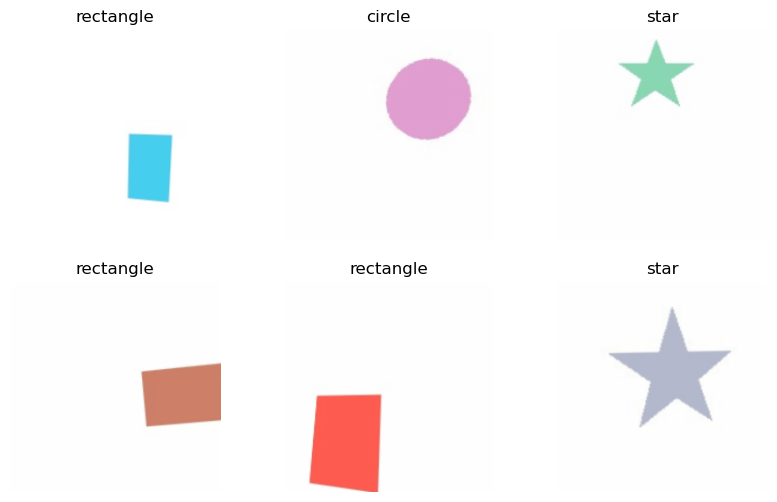

In [6]:
from fastai.vision.all import *
import warnings
warnings.filterwarnings('ignore')

def get_label(img_path):
    """Read YOLO format label."""
    label_path = LABEL_DIR / f"{img_path.stem}.txt"
    if label_path.exists():
        with open(label_path, 'r') as f:
            class_idx = int(f.read().strip())
            return LABELS[class_idx]
    return None

# Get all labeled images
labeled_images = get_labeled_images()

if len(labeled_images) < 5:
    print(f"Not enough labeled images ({len(labeled_images)}). Need at least 5 to train.")
    print("Please annotate more images first.")
else:
    print(f"Training on {len(labeled_images)} labeled images...")
    print()
    
    # Determine appropriate batch size based on dataset size
    batch_size = min(32, max(4, len(labeled_images) // 5))
    print(f"Using batch size: {batch_size}")
    
    # Create DataBlock
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=lambda x: labeled_images,
        get_y=get_label,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        item_tfms=Resize(IMAGE_SIZE),
        batch_tfms=aug_transforms(size=IMAGE_SIZE, min_scale=0.75)
    )
    
    # Create DataLoaders
    dls = dblock.dataloaders(IMAGE_DIR, bs=batch_size)
    
    # Verify data loaded correctly
    print(f"Training samples: {len(dls.train_ds)}")
    print(f"Validation samples: {len(dls.valid_ds)}")
    print()
    
    # Show sample if possible
    if len(dls.train_ds) > 0:
        print("Sample batch:")
        try:
            dls.show_batch(max_n=min(6, len(dls.train_ds)), figsize=(10, 6))
        except Exception as e:
            print(f"Could not display batch: {e}")
    
    # Create learner with ResNet34
    learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate])
    
    # Train
    print(f"\nTraining for {EPOCHS} epochs...")
    learn.fine_tune(EPOCHS, base_lr=LEARNING_RATE)
    
    # Save model
    model_path = MODEL_DIR / 'model.pkl'
    learn.export(model_path)
    print(f"\n✓ Model saved to {model_path}")

## 5. Validation Statistics

Display model performance metrics.

Loading model and recreating dataloaders...

Model Performance on 13 validation images:



Confusion Matrix:


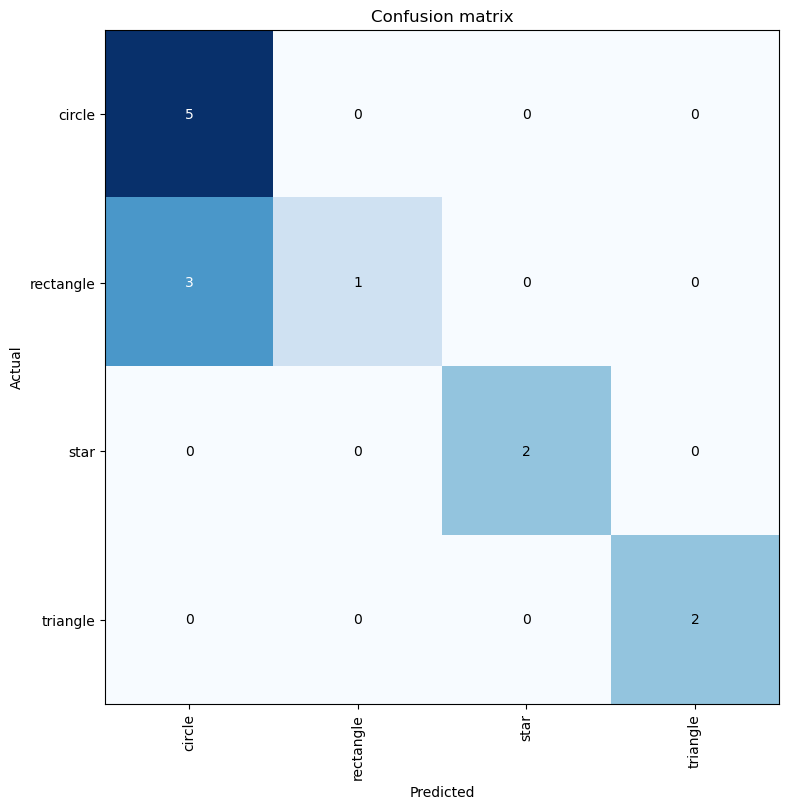


Top Losses (most confused predictions):


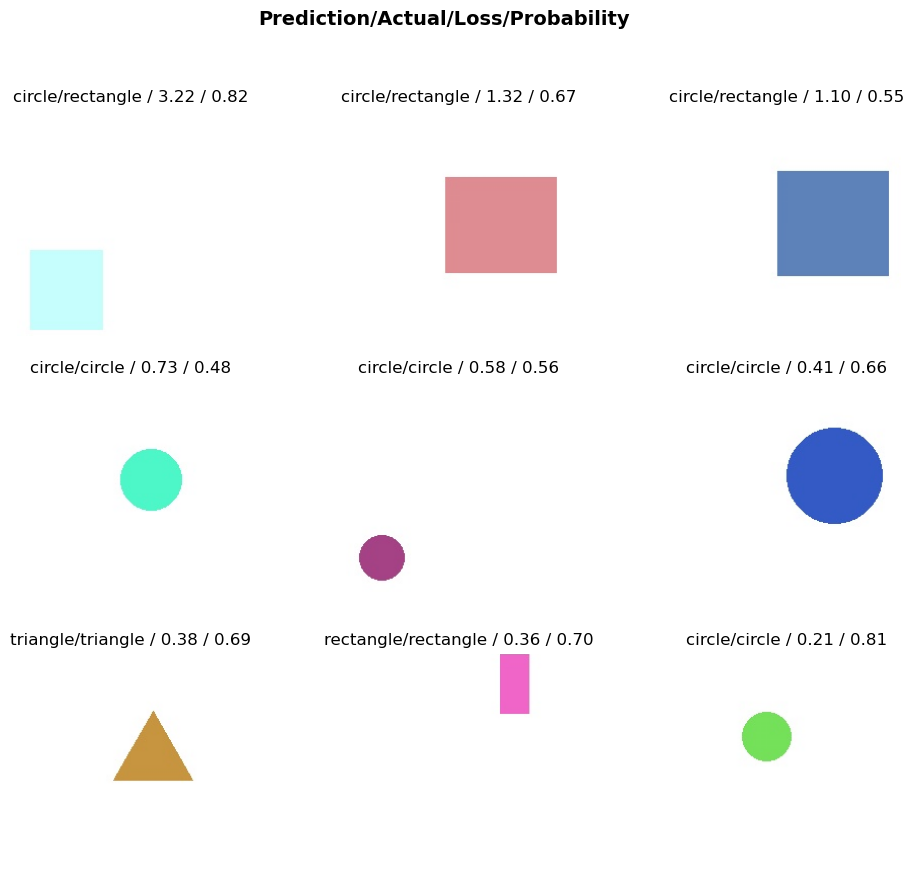


Detailed Classification Report:
              precision    recall  f1-score   support

      circle       0.62      1.00      0.77         5
   rectangle       1.00      0.25      0.40         4
        star       1.00      1.00      1.00         2
    triangle       1.00      1.00      1.00         2

    accuracy                           0.77        13
   macro avg       0.91      0.81      0.79        13
weighted avg       0.86      0.77      0.73        13



In [7]:
from fastai.vision.all import *
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model_path = MODEL_DIR / 'model.pkl'

if not model_path.exists():
    print("No model found. Please train a model first.")
else:
    print("Loading model and recreating dataloaders...")
    
    # Need to recreate dataloaders for interpretation
    def get_label(img_path):
        """Read YOLO format label."""
        label_path = LABEL_DIR / f"{img_path.stem}.txt"
        if label_path.exists():
            with open(label_path, 'r') as f:
                class_idx = int(f.read().strip())
                return LABELS[class_idx]
        return None
    
    labeled_images = get_labeled_images()
    batch_size = min(32, max(4, len(labeled_images) // 5))
    
    # Recreate DataBlock and DataLoaders
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=lambda x: labeled_images,
        get_y=get_label,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        item_tfms=Resize(IMAGE_SIZE),
        batch_tfms=aug_transforms(size=IMAGE_SIZE, min_scale=0.75)
    )
    
    dls = dblock.dataloaders(IMAGE_DIR, bs=batch_size)
    
    # Load the model
    learn = load_learner(model_path)
    learn.dls = dls  # Attach the dataloaders
    
    print(f"\nModel Performance on {len(dls.valid_ds)} validation images:\n")
    
    # Show interpretation
    interp = ClassificationInterpretation.from_learner(learn)
    
    # Confusion matrix
    print("Confusion Matrix:")
    interp.plot_confusion_matrix(figsize=(8, 8))
    plt.show()
    
    # Top losses (only if we have enough validation samples)
    if len(dls.valid_ds) >= 9:
        print("\nTop Losses (most confused predictions):")
        interp.plot_top_losses(9, figsize=(12, 10))
        plt.show()
    elif len(dls.valid_ds) > 0:
        print("\nTop Losses (most confused predictions):")
        n_losses = min(len(dls.valid_ds), 4)
        interp.plot_top_losses(n_losses, figsize=(10, 8))
        plt.show()
    
    # Classification report
    preds = learn.get_preds(dl=dls.valid)
    if len(preds) == 2:
        val_preds, val_targets = preds
    else:
        val_preds, val_targets = preds[0], preds[1]
    
    val_preds_classes = val_preds.argmax(dim=1)
    
    print("\nDetailed Classification Report:")
    print(classification_report(
        val_targets.numpy(), 
        val_preds_classes.numpy(), 
        target_names=LABELS,
        zero_division=0
    ))

## 6. Review Recent Annotations

Review and optionally delete the last 10 classifications.

Showing 10 most recent annotations:


1. circle_0196.jpg → circle
   Annotated: 2025-11-19 08:04:32


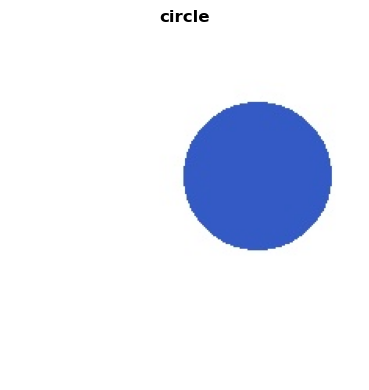


2. triangle_0146.jpg → triangle
   Annotated: 2025-11-19 08:04:30


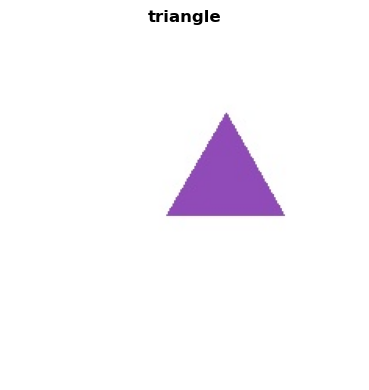


3. triangle_0101.jpg → triangle
   Annotated: 2025-11-19 08:04:30


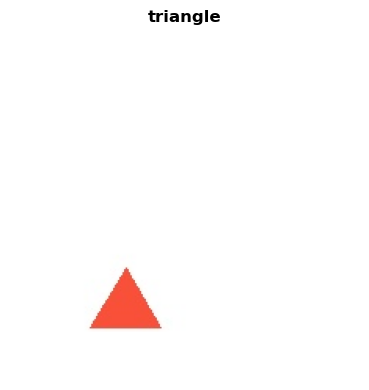


4. triangle_0092.jpg → triangle
   Annotated: 2025-11-19 08:04:28


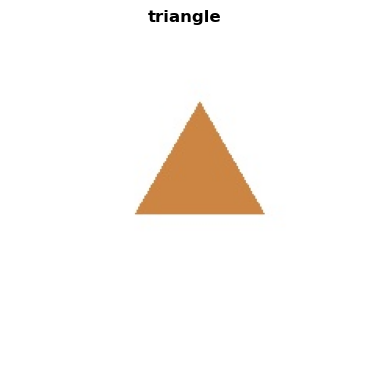


5. circle_0045.jpg → circle
   Annotated: 2025-11-19 08:04:27


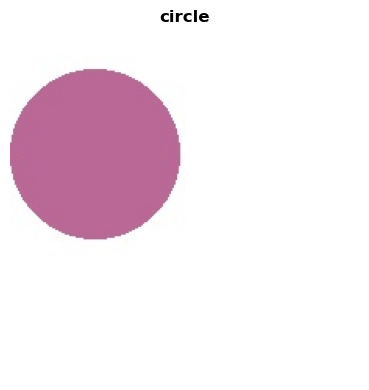


6. rectangle_0091.jpg → rectangle
   Annotated: 2025-11-19 08:04:26


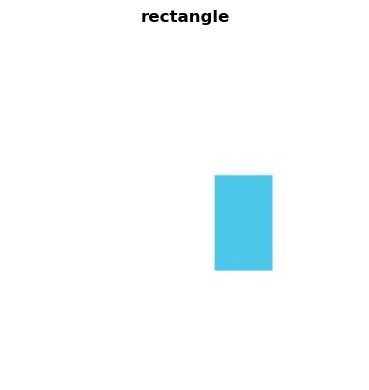


7. star_0169.jpg → star
   Annotated: 2025-11-19 08:04:25


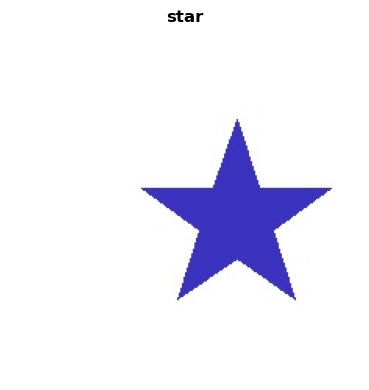


8. rectangle_0073.jpg → rectangle
   Annotated: 2025-11-19 08:04:25


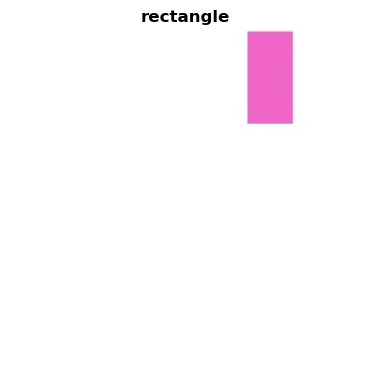


9. triangle_0076.jpg → triangle
   Annotated: 2025-11-19 08:04:23


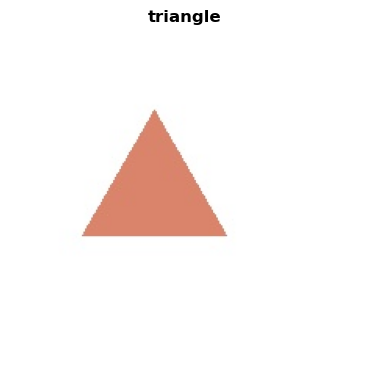


10. circle_0131.jpg → circle
   Annotated: 2025-11-19 08:04:22


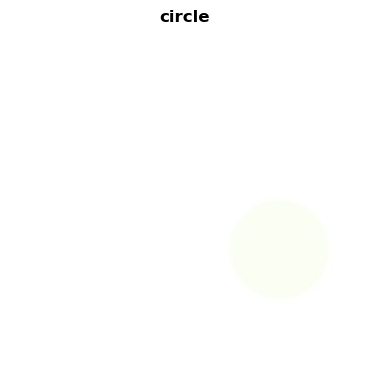


Note: After deleting labels, re-run the training cell to update the model.


In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime

def get_recent_labels(n=10):
    """Get the N most recently created label files."""
    label_files = list(LABEL_DIR.glob('*.txt'))
    label_files.sort(key=lambda x: x.stat().st_mtime, reverse=True)
    return label_files[:n]

def delete_label(label_path):
    """Delete a label file."""
    if label_path.exists():
        label_path.unlink()
        return True
    return False

def read_label(label_path):
    """Read label class from file."""
    with open(label_path, 'r') as f:
        class_idx = int(f.read().strip())
        return LABELS[class_idx]

# Get recent labels
recent_labels = get_recent_labels(10)

if len(recent_labels) == 0:
    print("No labels found.")
else:
    print(f"Showing {len(recent_labels)} most recent annotations:\n")
    
    for i, label_path in enumerate(recent_labels):
        img_path = IMAGE_DIR / f"{label_path.stem}.jpg"
        if not img_path.exists():
            img_path = IMAGE_DIR / f"{label_path.stem}.png"
        
        if img_path.exists():
            # Get label
            class_name = read_label(label_path)
            
            # Get timestamp
            timestamp = datetime.fromtimestamp(label_path.stat().st_mtime)
            
            print(f"\n{i+1}. {img_path.name} → {class_name}")
            print(f"   Annotated: {timestamp.strftime('%Y-%m-%d %H:%M:%S')}")
            
            # Display image
            img = Image.open(img_path)
            fig, ax = plt.subplots(figsize=(4, 4))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"{class_name}", fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Delete button
            delete_btn = widgets.Button(
                description=f"Delete annotation",
                button_style='danger',
                layout=widgets.Layout(width='200px')
            )
            
            output = widgets.Output()
            
            def on_delete(b, lp=label_path, ip=img_path):
                with output:
                    clear_output()
                    if delete_label(lp):
                        print(f"✓ Deleted label for {ip.name}")
                        b.disabled = True
                        b.description = "Deleted"
                        b.button_style = ''
            
            delete_btn.on_click(on_delete)
            display(widgets.VBox([delete_btn, output]))
    
    print("\n" + "="*50)
    print("Note: After deleting labels, re-run the training cell to update the model.")

---

## Next Steps

After completing one iteration:
1. Return to **Cell 2 (Sampling)** and re-run to get new images via active learning
2. Annotate the new batch in **Cell 3**
3. Re-train the model in **Cell 4**
4. Check improved metrics in **Cell 5**
5. Repeat until desired performance is achieved